In [5]:
import pandas as pd
from ai_cdss.constants import *
from ai_cdss.processing import expand_session_batch, expand_session_batch_optimized
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def filter_study_range(group):
    day_0 = group["SESSION_DATE"].min()
    study_range = group["SESSION_DATE"] <= day_0 + pd.Timedelta(days=43)
    return group[study_range]

In [3]:
clinical_scores = pd.read_csv("data/nest_T01.csv")
clinical_scores['DIFF'] = clinical_scores['T1'] - clinical_scores['T0']
data = pd.read_parquet("data/nest_data.parquet")

In [6]:
data['SESSION_DATE'] = data['SESSION_DATE'].dt.normalize()
data['PRESCRIPTION_STARTING_DATE'] = data['PRESCRIPTION_STARTING_DATE'].dt.normalize()
data = expand_session_batch_optimized(data)
study_data = data.groupby('PATIENT_ID', group_keys=False).apply(filter_study_range)
# Compute patient-level "Day Index"
study_data['DAY_INDEX'] = study_data.groupby('PATIENT_ID')['SESSION_DATE'].transform(
    lambda x: (x - x.min()).dt.days
)
study_data = study_data[BY_ID + ["PRESCRIPTION_STARTING_DATE", "PRESCRIPTION_ENDING_DATE"] + ["SESSION_DATE", "WEEKDAY_INDEX", "STATUS", "ADHERENCE", "DAY_INDEX"]]
study_data.drop_duplicates(subset=BY_ID + ["SESSION_DATE"], inplace=True)
study_data[ADHERENCE] = study_data[ADHERENCE].astype(int)
study_data.sort_values(by=BY_PP + ["SESSION_DATE", "DAY_INDEX"]).reset_index(drop=True, inplace=True)
study_data.to_parquet("data/nest_study_data.parquet", index=False)

/tmp/ipykernel_2953289/51199713.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  study_data = data.groupby('PATIENT_ID', group_keys=False).apply(filter_study_range)


### All plots

`figure generations`

In [ ]:
import os

directory = "nest_adherence_report"
os.makedirs(directory, exist_ok=True)
import matplotlib.pyplot as plt

# Get unique patients and protocols
for i, g in study_data.groupby(by=BY_PP):
    g.sort_values(by=["DAY_INDEX"], inplace=True)
    # display(g)
    plt.figure(figsize=(13, 5))
    sns.set_theme(style="white")
    sns.lineplot(
        data=g,
        x="DAY_INDEX",
        y="ADHERENCE",
        marker="o",
        linewidth=1,
        legend=False,
        errorbar=None,
    )
    plt.title(f"Adherence - Patient {i[0]} - Protocol {i[1]}")
    plt.xlabel("Day Index")
    plt.ylabel("Adherence")
    plt.xticks(range(0, 46, 1))
    plt.xticks(rotation=90)
    plt.ylim(-0.09, 1.09)
    plt.xlim(0, 45)
    
    plt.savefig(f"{directory}/adherence_{i[0]}_{i[1]}.png", dpi=300, bbox_inches="tight")
    plt.close()

`image encoded`

In [8]:
import base64
import os

html = ['<html><head><title>Adherence Report</title></head><body>']
html.append('<h1>Adherence Report: Protocols x Patients</h1>')
html.append('<table border="1" style="border-collapse: collapse;">')

patients = sorted(study_data[PATIENT_ID].unique())
protocols = sorted(study_data[PROTOCOL_ID].unique())

# Table header
html.append('<tr><th>Protocol \\ Patient</th>')
for patient in patients:
    html.append(f'<th>{patient}</th>')
html.append('</tr>')

# Table rows
for protocol in protocols:
    html.append(f'<tr><td><strong>{protocol}</strong></td>')
    for patient in patients:
        dir = 'nest_adherence'
        filename = f'adherence_{patient}_{protocol}.png'
        filepath = os.path.join(dir, filename)
        
        if os.path.exists(filepath):
            with open(filepath, "rb") as image_file:
                encoded = base64.b64encode(image_file.read()).decode('utf-8')
                img_tag = f'<img src="data:image/png;base64,{encoded}" width="200">'
                html.append(f'<td>{img_tag}</td>')
        else:
            html.append('<td> - </td>')  # Empty cell if no image
    html.append('</tr>')

html.append('</table></body></html>')

# Save HTML
output_path = 'nest_adherence/nest_adherence_report.html'
with open(output_path, 'w') as f:
    f.write('\n'.join(html))

print(f"✅ Report generated at: {output_path}")


✅ Report generated at: nest_adherence/nest_adherence_report.html


`image link`

In [46]:
html = ['<html><head><title>Adherence Report</title></head><body>']
html.append('<h1>Adherence Report: Protocols x Patients</h1>')
html.append('<table border="1" style="border-collapse: collapse;">')

patients = sorted(study_data[PATIENT_ID].unique())
protocols = sorted(study_data[PROTOCOL_ID].unique())

# Table header
html.append('<tr><th>Protocol \\ Patient</th>')
for patient in patients:
    html.append(f'<th>{patient}</th>')
html.append('</tr>')

# Table rows
for protocol in protocols:
    html.append(f'<tr><td><strong>{protocol}</strong></td>')
    for patient in patients:
        dir = 'nest_adherence'
        filename = f'adherence_{patient}_{protocol}.png'
        filepath = f'{dir}/{filename}'
        # Check if the file exists
        if os.path.exists(filepath):
            html.append(f'<td><img src="{filename}" width="200"></td>')
        else:
            html.append('<td> - </td>')  # Empty cell if no image
    html.append('</tr>')

html.append('</table></body></html>')

# Save HTML
with open('nest_adherence/adherence_report.html', 'w') as f:
    f.write('\n'.join(html))


### Summary

Plot average adherence per patient protocol in a heatmap and plot the histogram per protocol

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


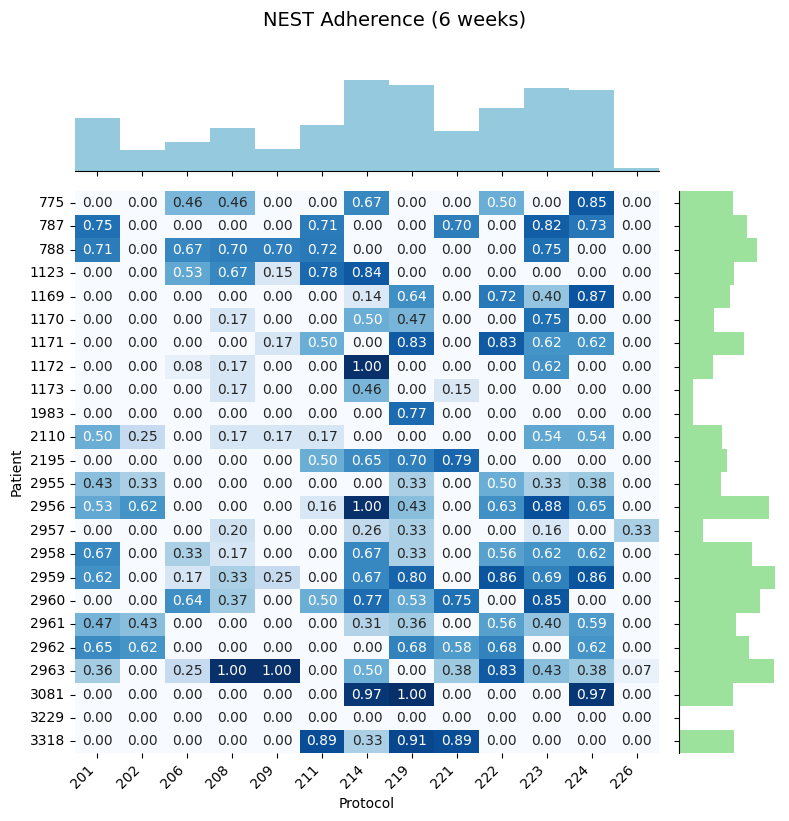

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Prepare data
adherence_summary = study_data.groupby(['PATIENT_ID', 'PROTOCOL_ID'])['ADHERENCE'].mean().reset_index()

# Pivot for heatmap
_toplot = adherence_summary.pivot(index='PATIENT_ID', columns='PROTOCOL_ID', values='ADHERENCE').fillna(0)

# Step 2: Create JointGrid
grid = sns.JointGrid(height=8)

# Center heatmap
sns.heatmap(
    _toplot,
    ax=grid.ax_joint,
    cbar=False,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    vmin=0, vmax=1
)

# Top marginal barplot: protocol mean
sns.barplot(
    x=_toplot.columns,
    y=_toplot.mean(axis=0),
    ax=grid.ax_marg_x,
    width=1,
    color='skyblue'
)

# Right marginal barplot: patient mean
sns.barplot(
    y=_toplot.index,
    x=_toplot.mean(axis=1),
    ax=grid.ax_marg_y,
    width=1,
    orient='h',
    color='lightgreen'
)

# Step 3: Adjust offsets (so bars align with heatmap cells)
_off = 0.5

# Fix x-axis
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin + _off, _xmax + _off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y-axis
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin + _off, _ymax + _off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Step 4: Labeling and styling
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(),
    rotation=45,
    ha='right'
)

grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Protocol')
grid.ax_joint.set_ylabel('Patient')

plt.suptitle('NEST Adherence (6 weeks)', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


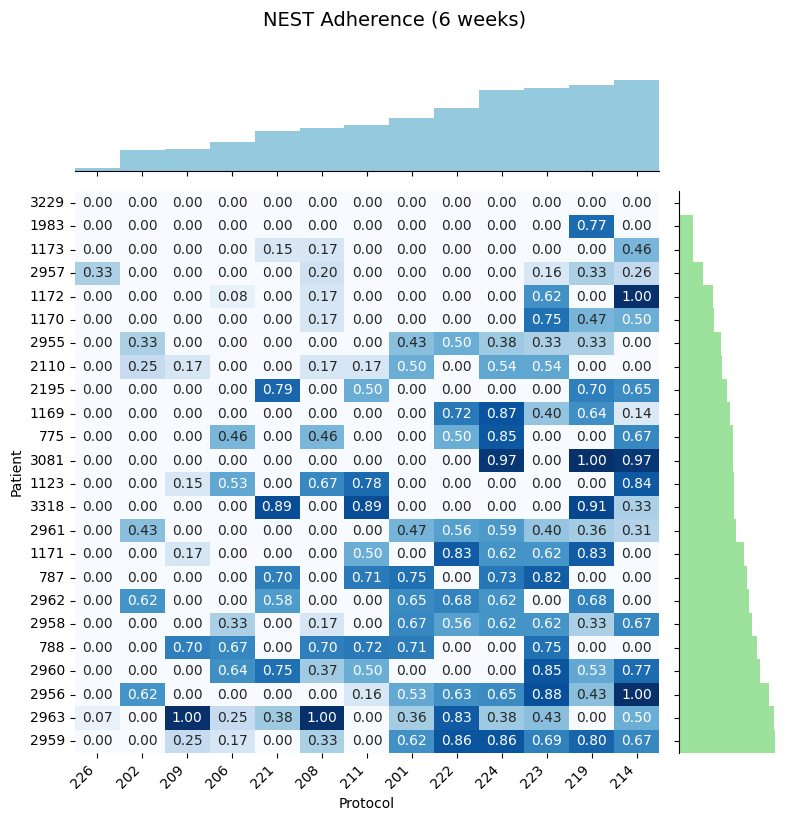

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Prepare data
adherence_summary = study_data.groupby(['PATIENT_ID', 'PROTOCOL_ID'])['ADHERENCE'].mean().reset_index()

# Pivot for heatmap
_toplot = adherence_summary.pivot(index='PATIENT_ID', columns='PROTOCOL_ID', values='ADHERENCE').fillna(0)

# Step 1.1: Order patients and protocols by increasing average adherence
protocol_order = _toplot.mean(axis=0).sort_values(ascending=True).index  # protocol adherence
patient_order = _toplot.mean(axis=1).sort_values(ascending=True).index   # patient adherence

# Reorder the DataFrame
_toplot = _toplot.loc[patient_order, protocol_order]

# 💡 Important: Precompute the ordered means
protocol_means_ordered = _toplot.mean(axis=0)
patient_means_ordered = _toplot.mean(axis=1)

# Step 2: Create JointGrid
grid = sns.JointGrid(height=8)

# Center heatmap
sns.heatmap(
    _toplot,
    ax=grid.ax_joint,
    cbar=False,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    vmin=0,
    vmax=1
)

# Top marginal barplot: protocol mean (force order!)
sns.barplot(
    x=_toplot.columns,
    y=protocol_means_ordered.values,
    ax=grid.ax_marg_x,
    width=1,
    color='skyblue',
    order=_toplot.columns  # ✅ force order
)

# Right marginal barplot: patient mean (force order!)
sns.barplot(
    y=_toplot.index,
    x=patient_means_ordered.values,
    ax=grid.ax_marg_y,
    width=1,
    orient='h',
    color='lightgreen',
    order=_toplot.index  # ✅ force order
)


# Step 3: Adjust offsets (so bars align with heatmap cells)
_off = 0.5

# Fix x-axis
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin + _off, _xmax + _off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y-axis
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin + _off, _ymax + _off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Step 4: Labeling and styling
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(),
    rotation=45,
    ha='right'
)

grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Protocol')
grid.ax_joint.set_ylabel('Patient')

plt.suptitle('NEST Adherence (6 weeks)', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# import numpy as np
# bins = np.linspace(0, 1, 11)  # 0.0, 0.1, 0.2, ..., 1.0

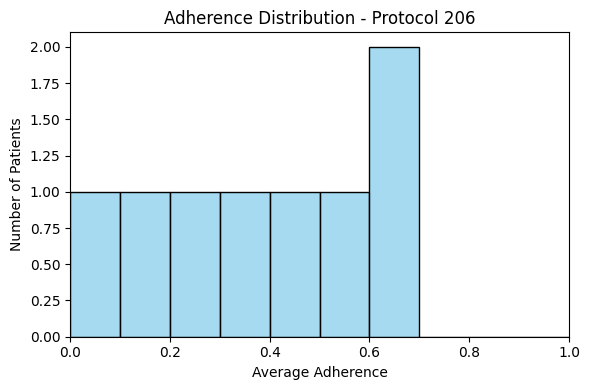

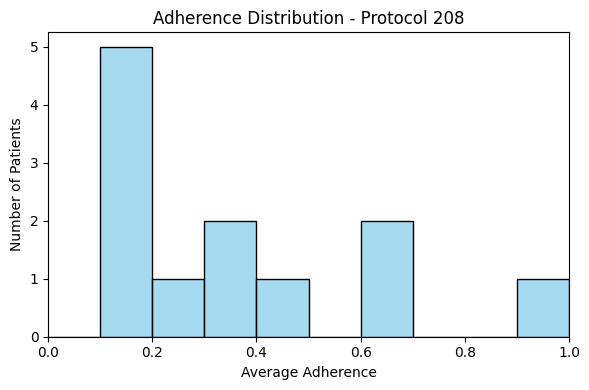

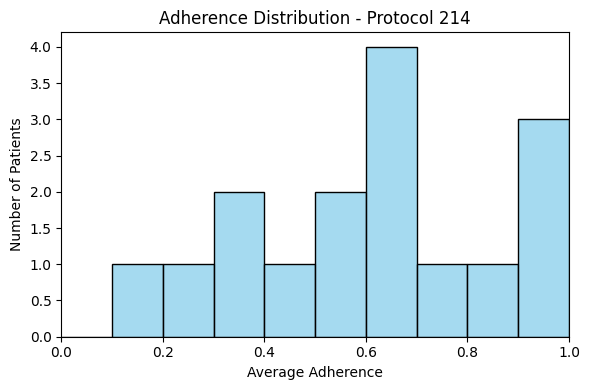

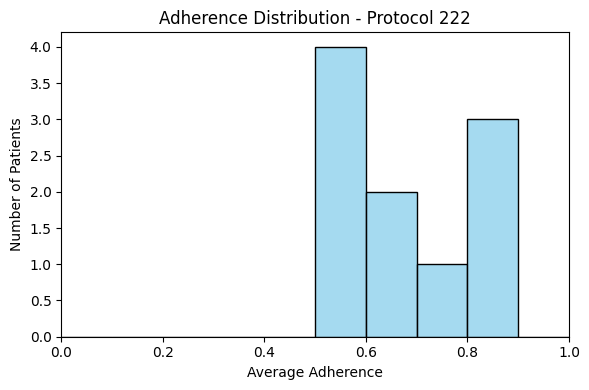

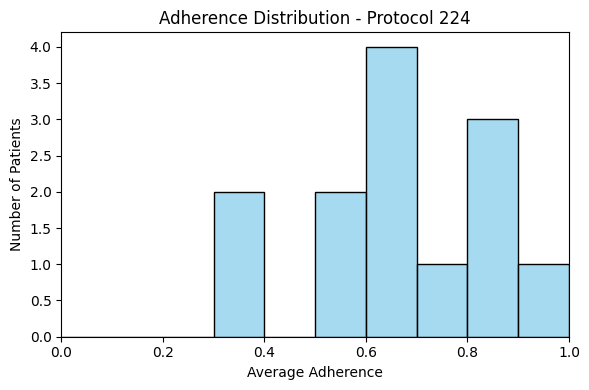

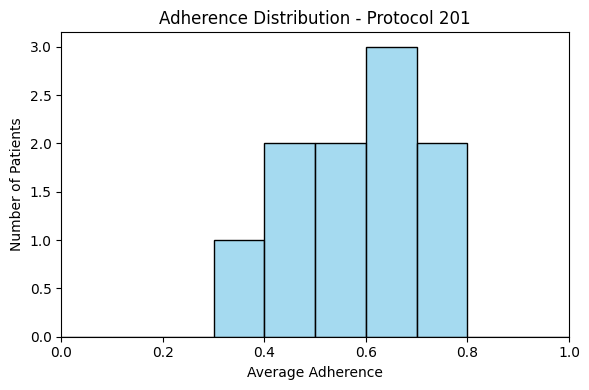

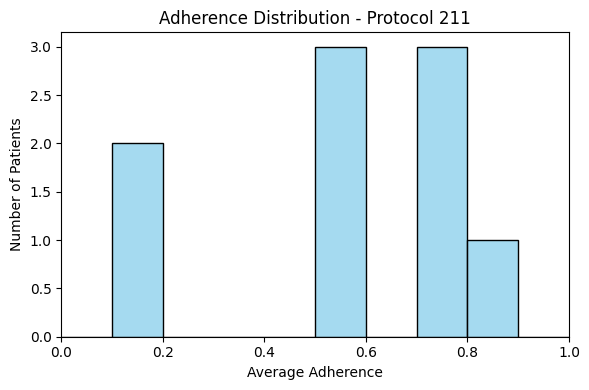

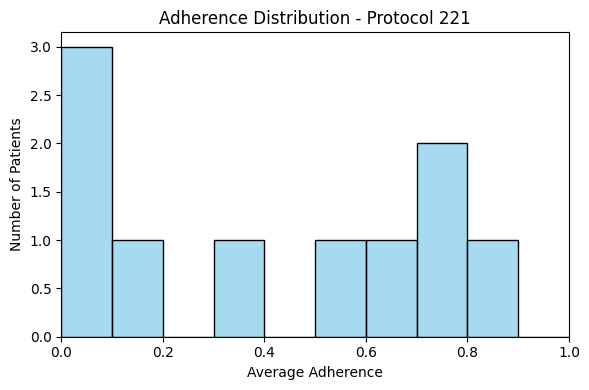

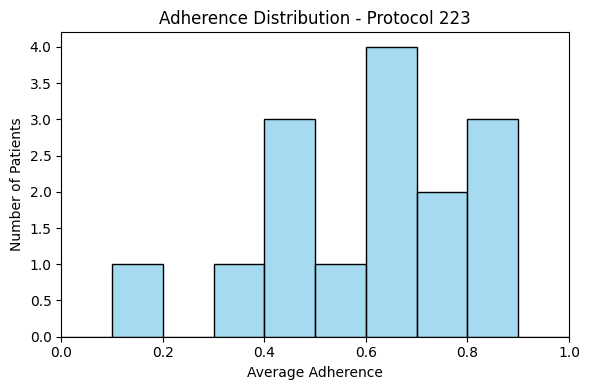

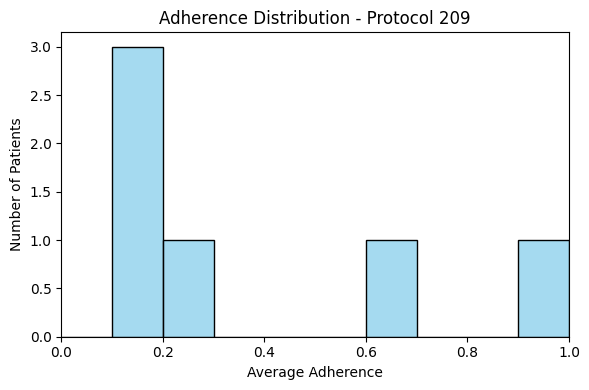

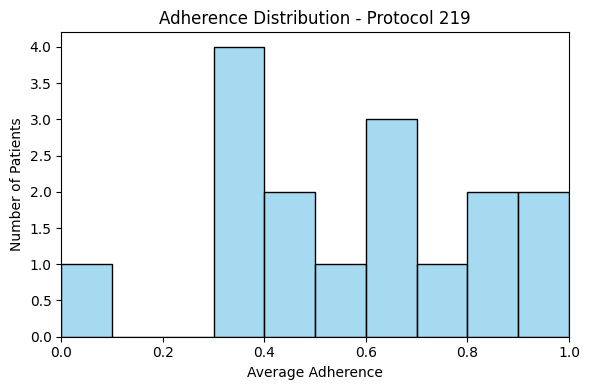

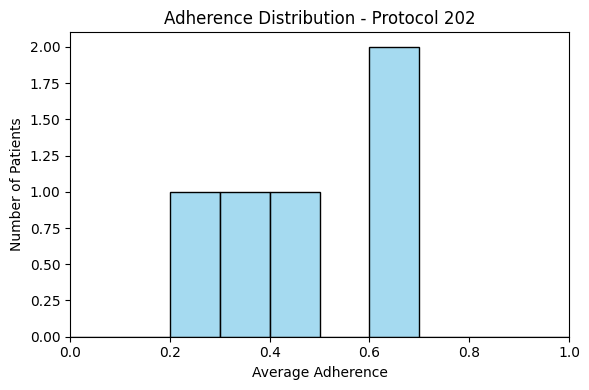

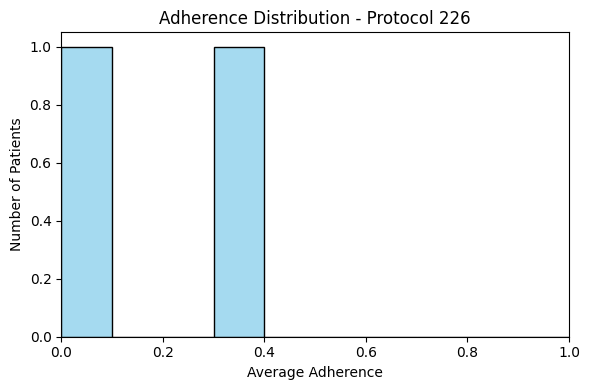

In [10]:
protocols = adherence_summary['PROTOCOL_ID'].unique()

for protocol in protocols:
    plt.figure(figsize=(6, 4))
    subset = adherence_summary[adherence_summary['PROTOCOL_ID'] == protocol]
    
    sns.histplot(
        subset['ADHERENCE'],
        bins=bins,
        kde=False,
        color='skyblue',
        edgecolor='black'
    )
    
    plt.title(f'Adherence Distribution - Protocol {protocol}')
    plt.xlabel('Average Adherence')
    plt.ylabel('Number of Patients')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()


### Intra-patient Variability

In [ ]:
def plot_adherence_variability(study_data, filename=None):
    # Step 1: Aggregate mean and SE manually
    adherence_summary = study_data.groupby("DAY_INDEX").agg(
        mean_adherence=('ADHERENCE', 'mean'),
        se_adherence=('ADHERENCE', lambda x: x.std(ddof=1) / (len(x) ** 0.5))
    ).reset_index()

    # Step 2: Plot
    plt.figure(figsize=(13, 5))
    sns.set_theme(style="white")

    # Line without error bar
    sns.lineplot(
        data=study_data,
        x="DAY_INDEX",
        y="ADHERENCE",
        # hue="WEEKEND",
        # marker="o",
        linewidth=2,
        errorbar=None,  # Disable internal error bar
    )

    # Add manual error bars
    plt.errorbar(
        adherence_summary["DAY_INDEX"],
        adherence_summary["mean_adherence"],
        yerr=adherence_summary["se_adherence"],
        fmt='none',
        # ecolor='gray',
        capsize=3,
        capthick=3,
        elinewidth=3
    )

    plt.title("Adherence Variability")
    plt.xlabel("Day Index")
    plt.ylabel("Adherence")
    plt.xticks(range(0, 46, 1))
    plt.xticks(rotation=90)
    plt.ylim(-0.09, 1.09)
    plt.xlim(0, 45)

    # plt.title(f"")

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    else:
        plt.show()

    plt.close()


In [10]:
# Add column indicating if prescription is a must or not depending on weekend
def is_weekend(row):
    if row['WEEKDAY_INDEX'] in [5, 6]:
        return 1
    else:
        return 0
study_data['WEEKEND'] = study_data.apply(is_weekend, axis=1)

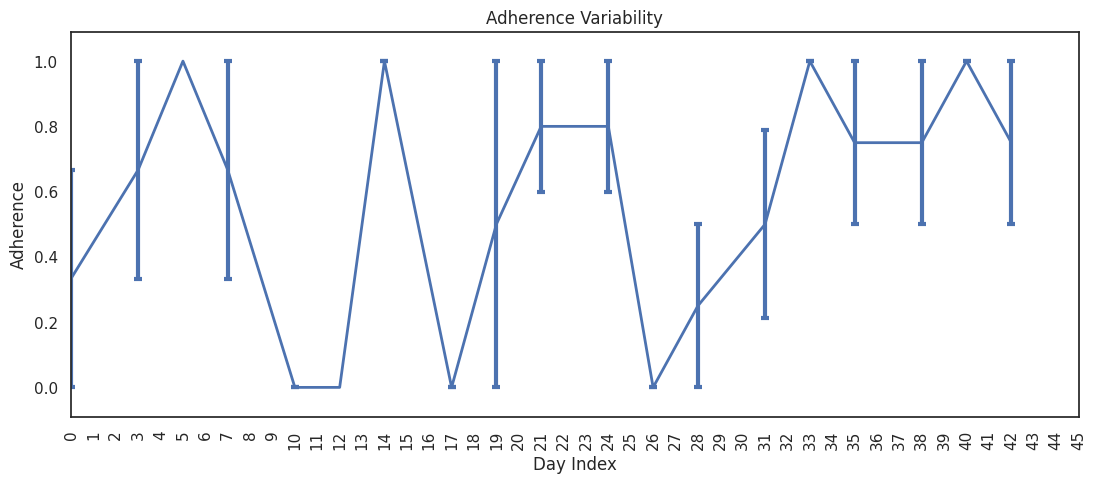

In [13]:
for i, g in study_data.groupby(by='PATIENT_ID'):
    plot_adherence_variability(g)#, filename=f"nest_adherence/adherence_variability_{g.name[0]}_{g.name[1]}.png")
    break